#오토인코더

오토인코더는 라벨 없이 원하는 출력값을 생성하는 모델. 따라서 비지도학습에 속한다.

In [ ]:
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F

import torch.nn as nn
import torch.optim as optim

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
#MNIST데이터 불러오기
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)

###오토 인코더 모델 생성

In [ ]:
class Flatten(nn.Module):
  def forward(self, x):
    batch_size = x.shape[0]
    return x.view(batch_size, -1)

class Unflatten(nn.Module):
  def __init__(self, k):
    super(Unflatten, self).__init__()
    self.k = k
  def forward(self, x):

    s = x.size()
    #벡터 사이즈 : 채널 수 * 이미지 너비 * 이미지 높이
    #벡터 사이즈 : 채널 수 * 이미지 사이즈**2
    #이미지 사이즈 = (벡터 사이즈//채널 수)**.5

    feature_size = int((s[1]//self.k)**.5)

    return x.view(s[0], self.k, feature_size, feature_size)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        k = 16
        self.encoder = nn.Sequential(
            nn.Conv2d(1, k, 3, stride=2),   # 28 -> 13
            nn.ReLU(),
            nn.Conv2d(k, 2*k, 3, stride=2), # 13 -> 6
            nn.ReLU(),
            nn.Conv2d(2*k, 4*k, 3, stride=1), # 6 -> 4
            nn.ReLU(),
            Flatten(),                  # 4*4*64 = 1024,
            nn.Linear(1024, 10),
            nn.ReLU(),
        )
        #latent Variable은 그 때 그 때 맞게 조정하면 됨.
        #10은 고차원의 이미지를 10차원으로 줄였다는 뜻. 단 Latent Variable의 크기는 성능과 반비계

        self.decoder = nn.Sequential(
            nn.Linear(10, 1024),
            nn.ReLU(),
            nn.Unflatten(1, (4*k, 4, 4)),              # (64,4,4)
            nn.ConvTranspose2d(4*k, 2*k, 3, stride=1), # 4 -> 6
            nn.ReLU(),
            nn.ConvTranspose2d(2*k, k, 3, stride=2),   # 6 -> 13
            nn.ReLU(),
            nn.ConvTranspose2d(k, 1, 3, stride=2, output_padding=1), # 13 -> 28
            nn.Sigmoid(),  # 출력 범위 [0,1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

###시각화 함수 만들기

In [ ]:
from re import L
def normalize_output(img):
  img = (img - img.min()) / (img.max()-img.min())
  return img

def check_plot():
  with torch.no_grad():
    for data in trainloader:

      inputs = data[0].to(device)
      outputs = model(inputs)

      input_samples = inputs.permute(0,2,3,1).cpu().numpy() #원래 이미지
      reconstructed_samples = outputs.permute(0,2,3,1).cpu().numpy() #생성 이미지

      break #배치 하나만 받고 for문 종료

  #reconstructed_samples = normalize_output(reconstructed_samples) : 0~1 사이로 변환
  #input_samples = normalize_output(input_samples) : 0~1 사이로 변환

  columns = 10 #시각화 전체 너비
  rows = 5 #시각화 전체 높이

  fig = plt.figure(figsize = (8, 4)) #figure 선언

  #원래 이미지 배치 크기만큼 보여주기
  for i in range(1, columns*rows +1):
    img = input_samples[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.squeeze())
    plt.axis('off')

  plt.show()

  fig = plt.figure(figsize = (8, 4))

  for i in range(1, columns*rows +1):
    img = reconstructed_samples[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.squeeze())
    plt.axis('off')

  plt.show()


In [ ]:
#손실함수 정의
criterion = nn.MSELoss()

[1] loss : 0.127704


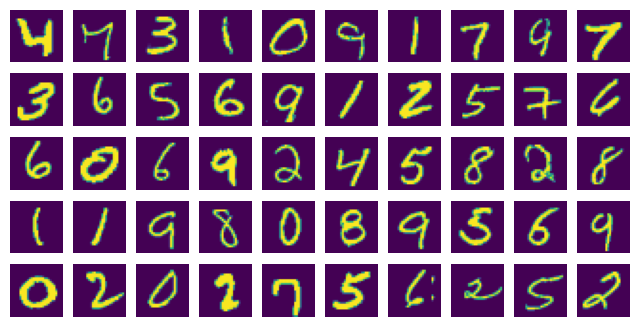

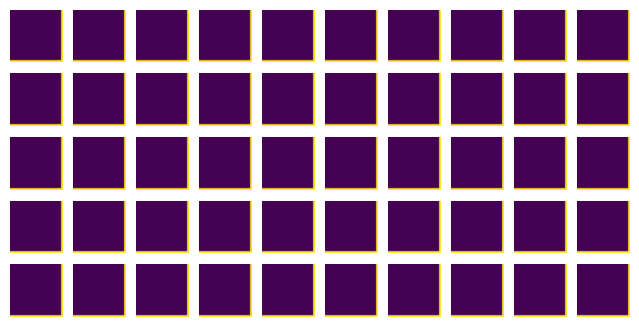

[11] loss : 0.112017


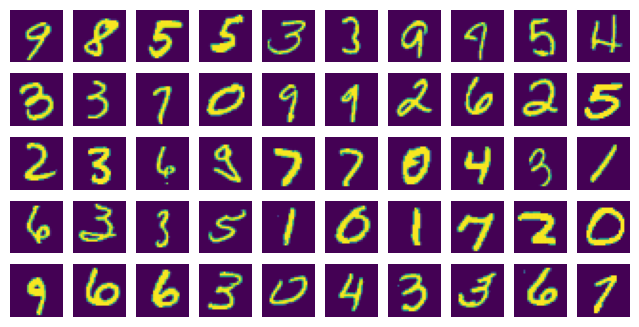

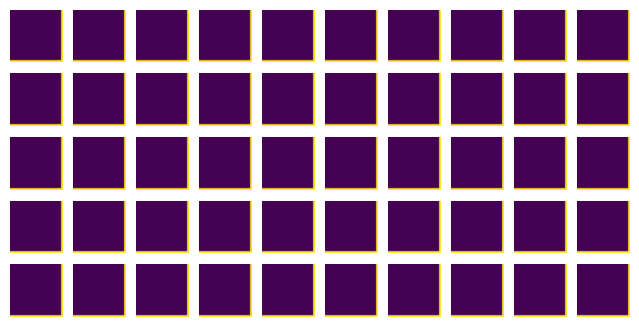

[21] loss : 0.044572


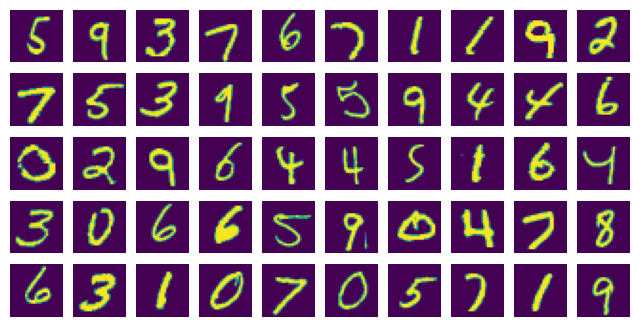

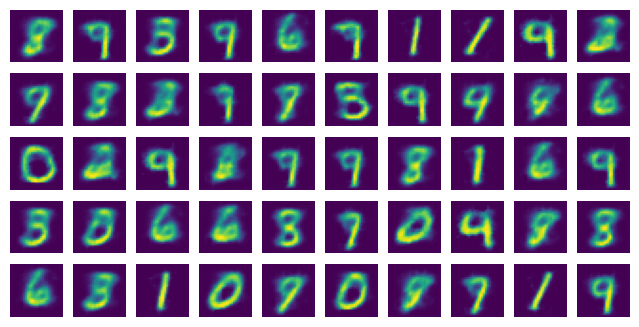

In [ ]:
for epoch in range(21):
  running_loss = 0.0

  for data in trainloader:
    inputs = data[0].to(device)

    optimizer.zero_grad()
    outputs = model(inputs)

    loss = criterion(inputs, outputs)

    loss.backward()
    optimizer.step()
    running_loss += loss.item()


  cost = running_loss / len(trainloader)

  if epoch % 10 ==0:
    print("[%d] loss : %3f"%(epoch + 1, cost))

    check_plot()

**오토인코더에서는 Latent Variable이 성능에 크게 영향을 미치므로 잘 확인해야 한다.**

---

